# Lab 4 Report 
## Surpass Human Performance in Fashion MNIST Classificaion

### Name: Owen Zhang


In [995]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [996]:
from IPython.display import Image # For displaying images in colab jupyter cell

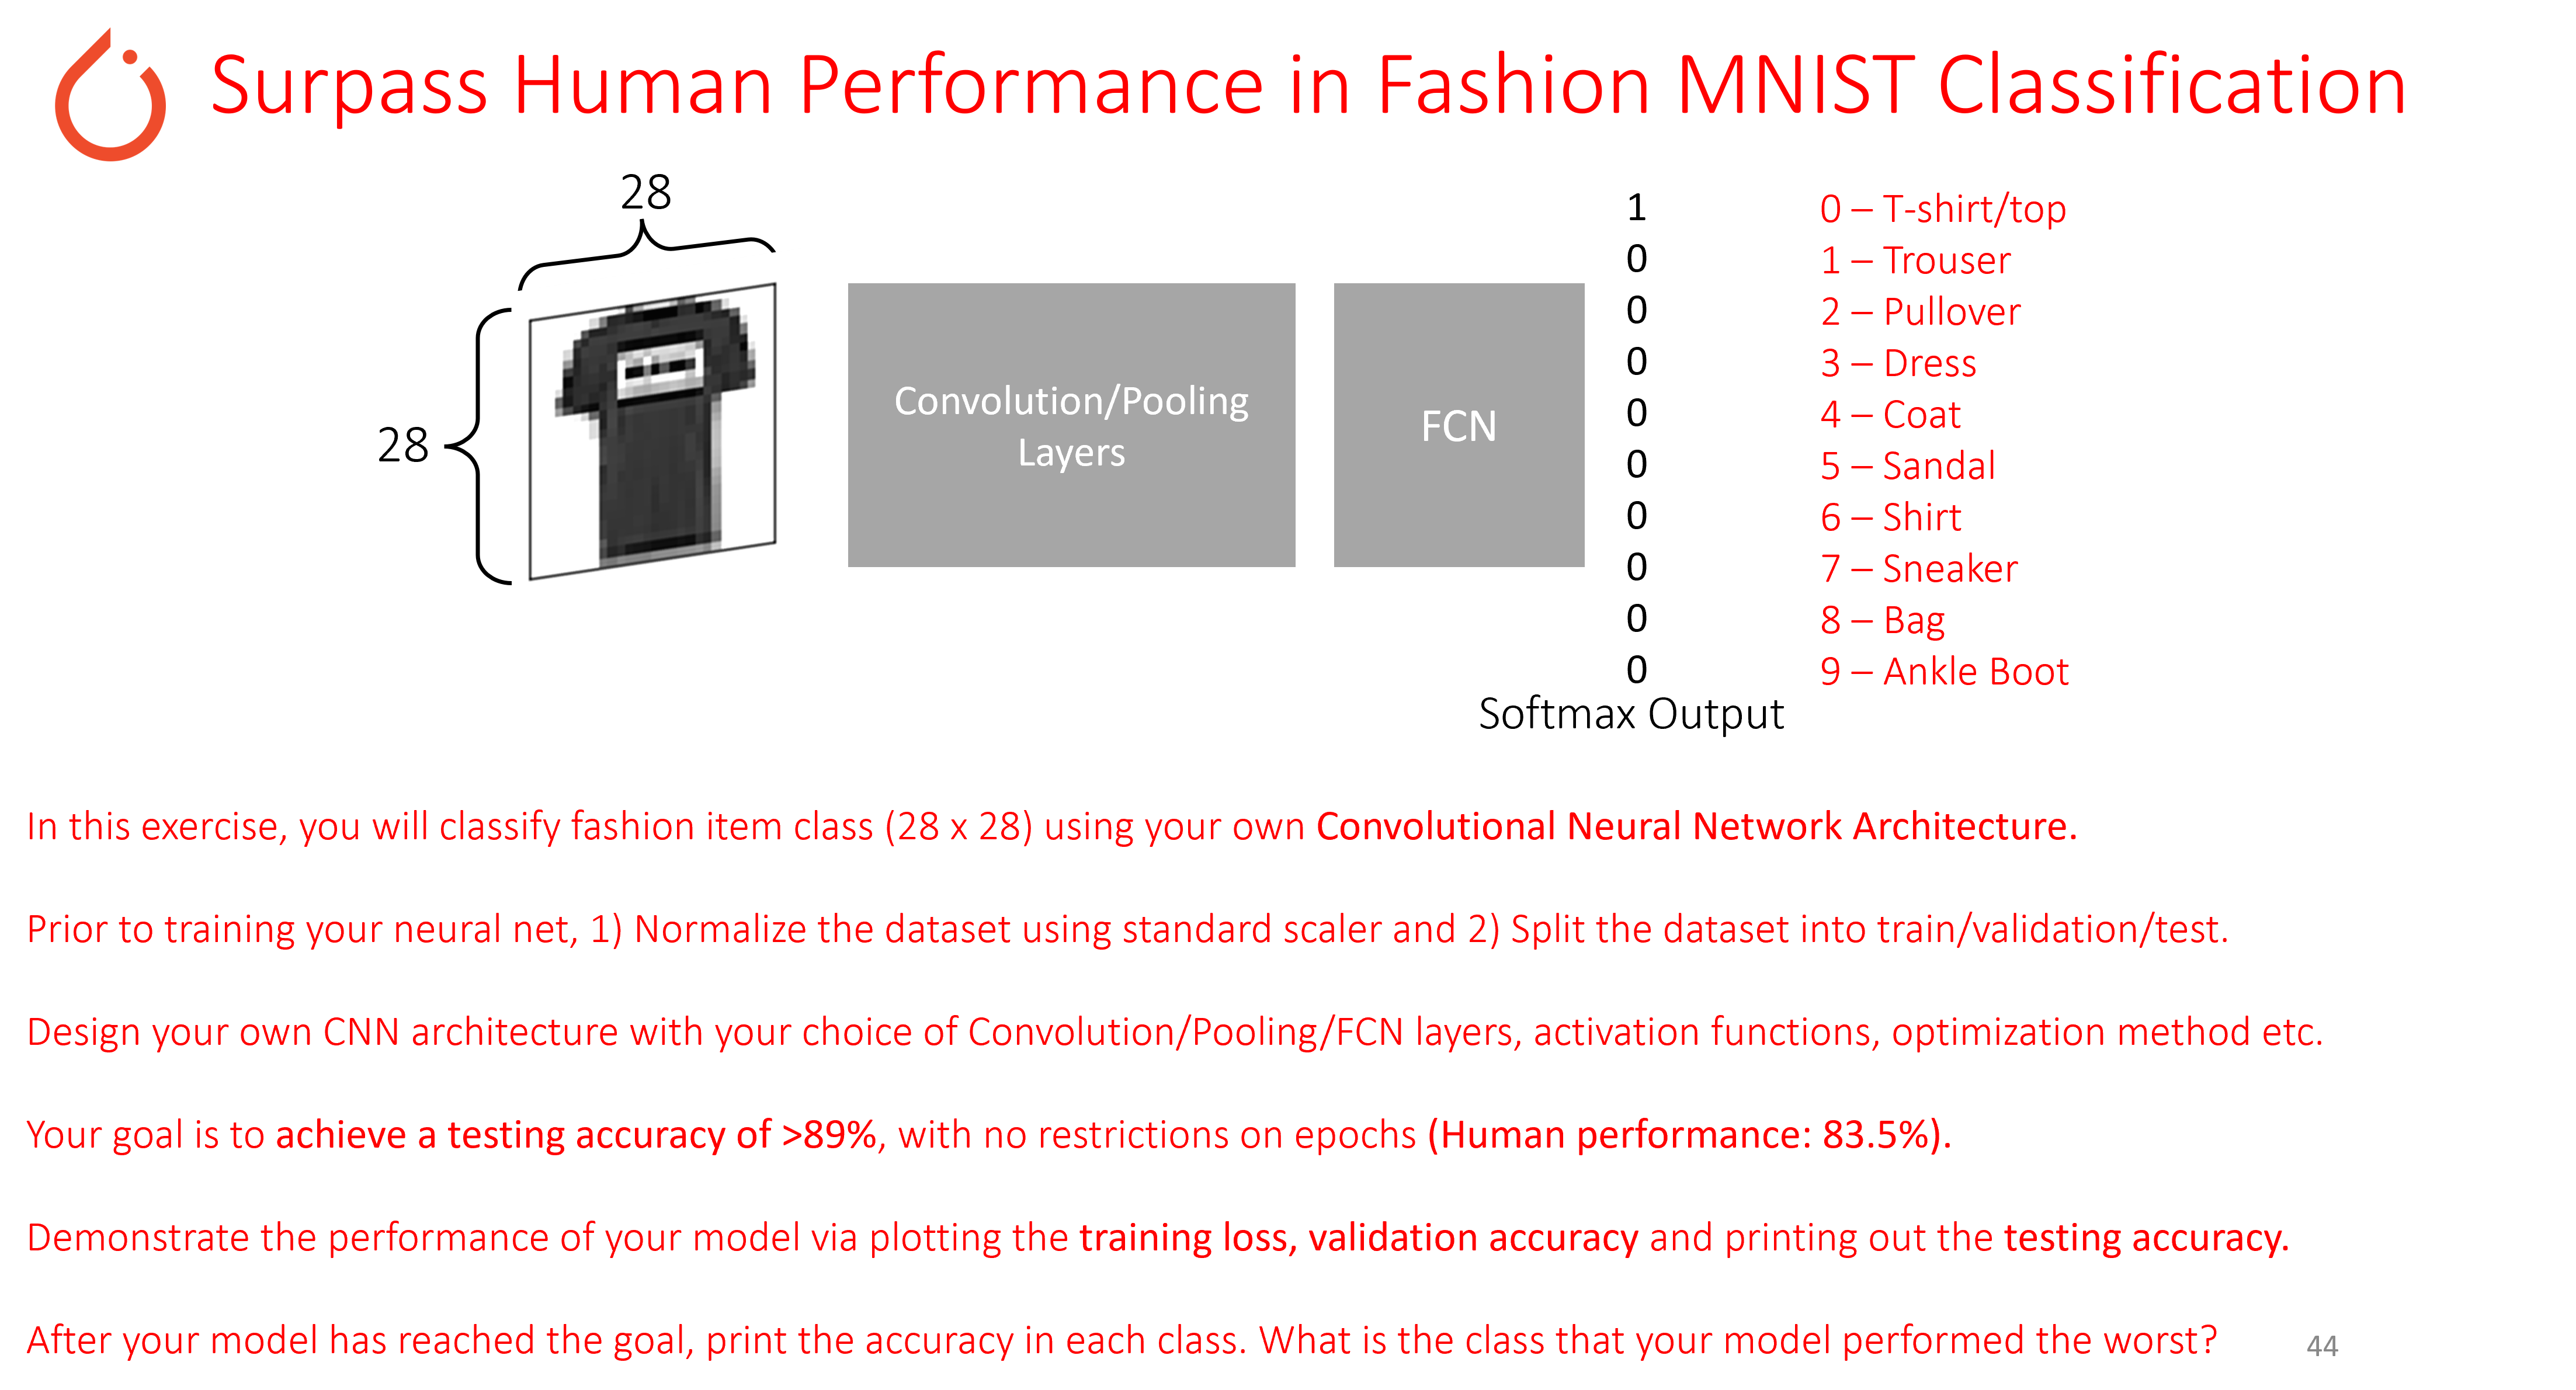

In [997]:
Image('lab4_exercise.png', width = 1000)

## Prepare Data

In [998]:
# Load Fashion-MNIST Dataset in Numpy

# 10000 training features/targets where each feature is a greyscale image with shape (28, 28)
train_features = np.load('fashion_mnist_train_features.npy') 
train_targets = np.load('fashion_mnist_train_targets.npy')

# 1000 testing features/targets 
test_features = np.load('fashion_mnist_test_features.npy')
test_targets = np.load('fashion_mnist_test_targets.npy')

# Let's see the shapes of training/testing datasets
print("Training Features Shape: ", train_features.shape)
print("Training Targets Shape: ", train_targets.shape)
print("Testing Features Shape: ", test_features.shape)
print("Testing Targets Shape: ", test_targets.shape)

Training Features Shape:  (10000, 28, 28)
Training Targets Shape:  (10000,)
Testing Features Shape:  (1000, 28, 28)
Testing Targets Shape:  (1000,)


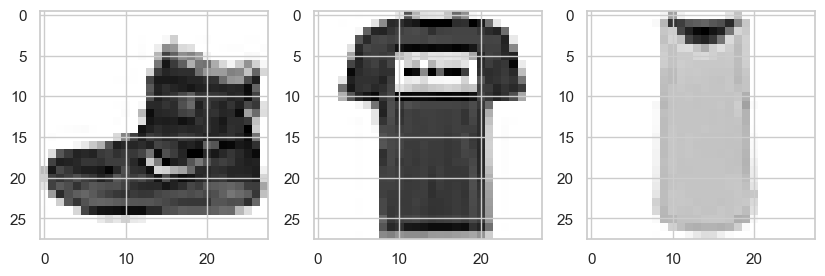

In [999]:
# Visualizing the first three training features (samples)

plt.figure(figsize = (10, 10))

plt.subplot(1,3,1)
plt.imshow(train_features[0], cmap = 'Greys')

plt.subplot(1,3,2)
plt.imshow(train_features[1], cmap = 'Greys')

plt.subplot(1,3,3)
plt.imshow(train_features[2], cmap = 'Greys')

In [1000]:
# Reshape features via flattening the images
# This refers to reshape each sample from a 2d array to a 1d array.
# hint: np.reshape() function could be useful here

train_features_flat = train_features.reshape((10000, 28*28))
test_features_flat = test_features.reshape((1000, 28*28))


In [1001]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features_flat).reshape((10000, 28, 28))
test_features = scaler.fit_transform(test_features_flat).reshape((1000, 28, 28))

In [1002]:
# Take the first 1000 (or randomly select 1000) training features and targets as validation set 

k = int(0.1*len(train_features))
val_features = train_features[:k]
val_targets = train_targets[:k]

# Take the remaining 9000 training features and targets as training set 

train_features = train_features[k:]
train_targets = train_targets[k:]

print(np.shape(train_features)[0])

9000


In [1003]:
# Reshape train/validation/test sets to conform to PyTorch's (N, Channels, Height, Width) standard for CNNs

train_features = train_features.reshape((9000, 1, 28, 28))
val_features = val_features.reshape((1000, 1, 28 ,28))
test_features = test_features.reshape((1000, 1, 28, 28))


## Define Model

In [1004]:
# Define your CNN architecture here

class CNNModel(torch.nn.Module):
    
    def __init__(self):
        
        super(CNNModel, self).__init__()
        
         # First convolution layer (1 channel -> 16 channels, preserve original dimension by adding padding = 2)
        self.cnn1 = torch.nn.Conv2d(in_channels=1, out_channels=16, 
                              kernel_size=3, stride=1, padding=1)
        
        # First max pooling layer with kernel size = 2
        self.maxpool1 = torch.nn.MaxPool2d(kernel_size=2)
         
        # Second convolution layer (16 channel -> 32 channels, preserve dimension by adding padding = 2)
        self.cnn2 = torch.nn.Conv2d(in_channels=16, out_channels=32, 
                              kernel_size=3, stride=1, padding=1)
        
        # Second max pooling layer with kernel size = 2
        self.maxpool2 = torch.nn.MaxPool2d(kernel_size=2)
        
        # Fully connected layer that takes the flattened output of maxpool2 (32, 7 ,7) -> (1568) and output 10 classes
        self.fc1 = torch.nn.Linear(32 * 7 * 7, 10) 
        
    
    def forward(self, x):
        
        # YOUR CODE HERE
        # Note: If you are using CrossEntropyLoss() do NOT apply softmax to the final ouput 
        # since it's incorporated within the loss function
        # input image -> conv1 -> relu -> maxpool1
        conv1_out = torch.nn.functional.relu(self.cnn1(x))       
        pool1_out = self.maxpool1(conv1_out)
        
        # maxpool1 output -> conv2 -> relu -> maxpool2
        conv2_out = torch.nn.functional.relu(self.cnn2(pool1_out))    
        pool2_out = self.maxpool2(conv2_out)
        
        # flatten the maxpool2 output to be used as input into FCN layer
        fcn_input = pool2_out.view(pool2_out.size(0), -1)
    
        # Use the raw output of the fully connected layer as the final output
        output = self.fc1(fcn_input)
        
        return output

## Select Hyperparameters

In [1005]:
# Fix the random seed so that model performance is reproducible
torch.manual_seed(128)

# Initialize your CNN model

model = CNNModel()

# Define learning rate, epoch and batchsize for mini-batch gradient

learning_rate = 0.0028
epochs = 9
batchsize = 180

# Define loss function and optimizer

loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

model

CNNModel(
  (cnn1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=10, bias=True)
)

## Identify Tracked Values

In [1006]:
# Placeholders for training loss and validation accuracy during training
# Training loss should be tracked for each iteration (1 iteration -> single forward pass to the network)
# Validation accuracy should be evaluated every 'Epoch' (1 epoch -> full training dataset)
# If using batch gradient, 1 iteration = 1 epoch

train_loss_list = []
validation_accuracy_list = np.zeros((epochs,))

## Train Model

In [1007]:
import tqdm # Use "for epoch in tqdm.trange(epochs):" to see the progress bar

# Convert the training, validation, testing dataset (NumPy arrays) into torch tensors
# Split your training features/targets into mini-batches if using mini-batch gradient
train_inputs_torch = torch.from_numpy(train_features).float()
train_targets_torch = torch.from_numpy(train_targets).long()

val_inputs_torch = torch.from_numpy(val_features).float()
val_targets_torch = torch.from_numpy(val_targets).long()

testing_inputs_torch = torch.from_numpy(test_features).float()
testing_targets_torch = torch.from_numpy(test_targets).long()

train_batches_features = torch.split(train_inputs_torch, batchsize)
train_batches_targets = torch.split(train_targets_torch, batchsize)

# YOUR CODE HERE
mini_batches = len(train_batches_features)

# Training Loop ---------------------------------------------------------------------------------------

for epoch in range(epochs):
    for k in range(mini_batches):
        optimizer.zero_grad()
        train_batch_outputs = model(train_batches_features[k])
        loss = loss_func(train_batch_outputs, train_batches_targets[k])
        train_loss_list.append(loss.item())
        loss.backward()
        optimizer.step()
        #print('epoch {}, loss {}'.format(epoch, loss.item()))
    # Compute Validation Accuracy ----------------------------------------------------------------------
    with torch.no_grad():
        validation_outputs = model(val_inputs_torch)
        correct = (torch.argmax(validation_outputs, dim=1) == 
                   val_targets_torch).type(torch.FloatTensor)
        validation_accuracy_list[epoch] = correct.mean()
    print('epoch {}, accuracy {}'.format(epoch, np.round(100*validation_accuracy_list[epoch], 2)))

epoch 0, accuracy 82.4
epoch 1, accuracy 86.6
epoch 2, accuracy 88.3
epoch 3, accuracy 88.0
epoch 4, accuracy 88.1
epoch 5, accuracy 88.0
epoch 6, accuracy 87.9
epoch 7, accuracy 88.2
epoch 8, accuracy 88.7


## Visualize & Evaluate Model

In [1008]:
# Seaborn for prettier plot

import seaborn as sns

sns.set(style = 'whitegrid', font_scale = 1)

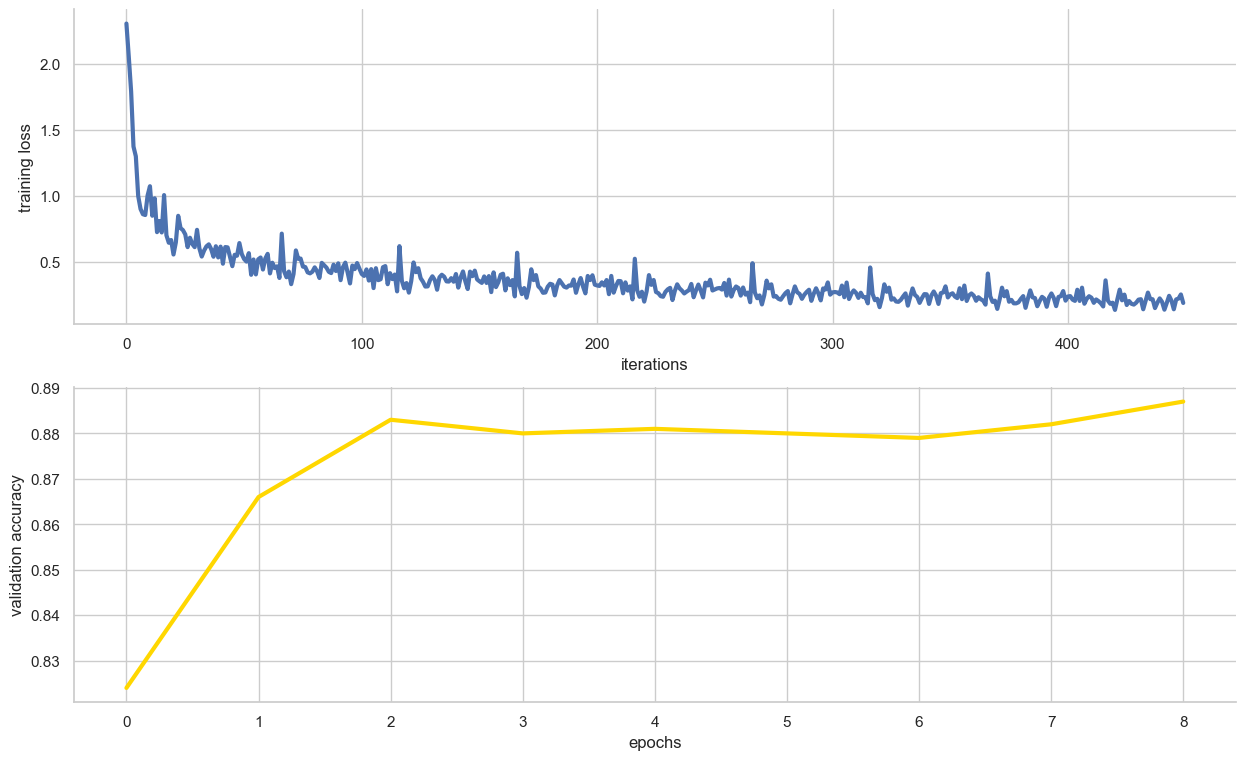

In [1009]:
# Visualize training loss

plt.figure(figsize = (15, 9))

plt.subplot(2, 1, 1)
plt.plot(train_loss_list, linewidth = 3)
plt.ylabel("training loss")
plt.xlabel("iterations")
sns.despine()

plt.subplot(2, 1, 2)
plt.plot(validation_accuracy_list, linewidth = 3, color = 'gold')
plt.ylabel("validation accuracy")
plt.xlabel("epochs")
sns.despine()

In [1010]:
# Compute the testing accuracy 

# YOUR CODE HERE
test_features = torch.from_numpy(test_features).float()
test_outputs = model(test_features).detach().numpy()
correct = (np.argmax(test_outputs, axis=1) == test_targets).sum()
print("Cumulative Accuracy: " + str(correct/np.shape(test_outputs)[0]*100) + "%.")

Cumulative Accuracy: 89.3%.


In [1011]:
# (OPTIONAL) Print the testing accuracy for each fashion class. Your code should produce something that looks like:
# Clever usage of np.where() could be useful here

# "Accuracy of T-shirt/top: 93.5 %"
# "Accuracy of Trouser: 89.3 %"
# etc...

# What's the fashion item that your model had the hardest time classifying?

correct_categories = np.zeros((10,))
wrong_categories = np.zeros((10,))
for i in range(np.shape(test_outputs)[0]):
    if np.argmax(test_outputs[i]) == test_targets[i]:
        correct_categories[test_targets[i]] += 1
    else:
        wrong_categories[test_targets[i]] += 1

features = ["t-shirts/tops", "trousers", "pullovers", "dresses", "coats", "sandals", "shirts", "sneakers", "bags", "ankle boots"]
for j in range(10):
    print("The model correctly identified " + str(np.round(correct_categories[j]/(correct_categories[j]+wrong_categories[j])*100, 2)) + "% of " + str(features[j]) + " as " + str(features[j]) + ".")

print("The hardest items to identify were " + features[np.argmin(correct_categories/(correct_categories+wrong_categories))] + ".")
print("The easiest items to identify were " + features[np.argmax(correct_categories/(correct_categories+wrong_categories))] + ".")

The model correctly identified 88.79% of t-shirts/tops as t-shirts/tops.
The model correctly identified 97.14% of trousers as trousers.
The model correctly identified 86.49% of pullovers as pullovers.
The model correctly identified 82.8% of dresses as dresses.
The model correctly identified 84.35% of coats as coats.
The model correctly identified 89.66% of sandals as sandals.
The model correctly identified 75.26% of shirts as shirts.
The model correctly identified 98.95% of sneakers as sneakers.
The model correctly identified 97.89% of bags as bags.
The model correctly identified 92.63% of ankle boots as ankle boots.
The hardest items to identify were shirts.
The easiest items to identify were sneakers.
